# Parse DrugBank data concerning Blood Brain Barrier (BBB) prediction

This requires a full database provided by DrugBank, adjust `path_drugbank_unzipped`. 

We used a version downloaded 03/01/2024


In [2]:
import xmltodict
import json
import os
path_drugbank_unzipped = os.path.expanduser("~/Downloads/full database.xml")

with open(path_drugbank_unzipped, "rb") as f:
    db_data = xmltodict.parse(f)
db_data = (json.
           loads(json.dumps(db_data)))    

print("Total number of drugs:", len(db_data["drugbank"]["drug"]))

Total number of drugs: 16575


In [3]:
import requests_cache
from requests.adapters import HTTPAdapter, Retry
from functools import cache

@cache
def get_drugbank_session():
    session=requests_cache.CachedSession("_drugbank_session", allowable_codes=[200], allowable_methods=["GET", "POST"])
    retries_adapter = HTTPAdapter(max_retries=Retry(total=5, backoff_factor=0.25))
    session.mount('http://', retries_adapter)
    session.mount('https://', retries_adapter)
    return session

In [4]:
import re
import pandas as pd
r = r"<td>Blood Brain Barrier</td><td>([-|+])</td><td>([\d|\.]*)<"
res = []

for i, d in enumerate(db_data["drugbank"]["drug"]):
    if d["@type"] == "small molecule":
        if type(d["drugbank-id"]) == list: 
            if len( d["drugbank-id"]) < 1:
                print("No DB id present in ", d["drugbank-id"], "name:", d["name"])
            else:
                db_id = d["drugbank-id"][0]["#text"]
        elif type(d["drugbank-id"]) == dict:
            db_id = d["drugbank-id"]["#text"]
        else:
            raise RuntimeError(f"Cannot extract drugbank-id {d['drugbank-id']}")
        assert db_id
        
        drugbank_data = get_drugbank_session().get(f"https://go.drugbank.com/drugs/{db_id}")
        found_bbb = re.findall(r, drugbank_data.text)
        bbb_class, bbb_prob = found_bbb[0] if found_bbb else (None, None)
        
        chembl_id = None
        if "external-identifiers" in d and d["external-identifiers"] is not None:
            #assert "external-identifier" in , d["external-identifiers"]
            eis = d["external-identifiers"]["external-identifier"]
            if type(eis) == list:
                cid_c = []
                for ei in eis: # double nested
                    if type(ei) == str:
                        assert False, ei
                    if ei["resource"] == "ChEMBL":
                        cid_c.append(ei["identifier"])
                if len(cid_c) > 1:
                    assert False, f"too many ChEMBL identifiers found {cid_c}"
                if len(cid_c) == 1:
                    chembl_id = cid_c[0]
            elif type(eis) == dict:
                if eis["resource"] == "ChEMBL":
                    chembl_id = eis["identifier"]
            else:
                assert False
        
        assert type(d["groups"]) == dict, d["groups"]
        groups = d["groups"]["group"]
        if type(groups) == str:
            groups = [groups]
        
        res.append({
            "drugbank_id": db_id,
            "chembl_id": chembl_id,
            "name": d["name"],
            "groups": groups,
            "BBB_class": bbb_class,
            "bbb_prob": bbb_prob,
        })
        #res.append((d, drugbank_data.text))
        if len(res) > 50000:
            break


df_db_small_molecule_drug_permeability = pd.DataFrame(res)

_target = "drugbank_data.csv"
print(f"Persisting {len(df_db_small_molecule_drug_permeability)} DrugBank small molecule drug records to {_target}")
df_db_small_molecule_drug_permeability.to_csv(_target, index=False)

df_db_small_molecule_drug_permeability.describe(include="all")

Persisting 12695 DrugBank small molecule drug records to drugbank_data.csv


,drugbank_id,chembl_id,name,groups,BBB_class,bbb_prob
count,12695,8327,12695,12695,6586,6586
unique,12695,8327,12695,50,2,2973
top,DB00006,CHEMBL2103749,Bivalirudin,[experimental],+,0.9382
freq,1,1,1,5887,5232,57


In [6]:
print("Permeability class across all small molecule DrugBank records")
df_db_small_molecule_drug_permeability.BBB_class.value_counts(dropna=False)

Permeability class across all small molecule DrugBank records


BBB_class
None    6109
+       5232
-       1354
Name: count, dtype: int64

In [7]:
df_db_drugs = df_db_small_molecule_drug_permeability[df_db_small_molecule_drug_permeability.groups.apply(lambda x: ("approved" in x or "investigational" in x) and "withdrawn" not in x)]

print("BBB permeability across approved and investigational and not withdrawn drugs:")
df_db_drugs.BBB_class.value_counts(dropna=False)

BBB permeability across approved and investigational and not withdrawn drugs:


BBB_class
None    4524
+       1286
-        422
Name: count, dtype: int64

In [8]:
_df_approved_only = df_db_small_molecule_drug_permeability[df_db_small_molecule_drug_permeability.groups.apply(lambda x: ("approved" in x) and "withdrawn" not in x)]
print("BBB permeability across approved and not withdrawn drugs:")
_df_approved_only.BBB_class.value_counts(dropna=False)

BBB permeability across approved and not withdrawn drugs:


BBB_class
None    1193
+       1034
-        346
Name: count, dtype: int64

### Coverage / linkage with ChEMBL drugs
A verification of the identifier resolution across DrugBank and ChEMBL drug set used in analysis.

In [10]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..", "b3db_kc")))
from utils import get_chembl_drugs
df_chembl_drugs = get_chembl_drugs()

Total DrugBank investigational / approved drugs without ChEMBL id: 1629


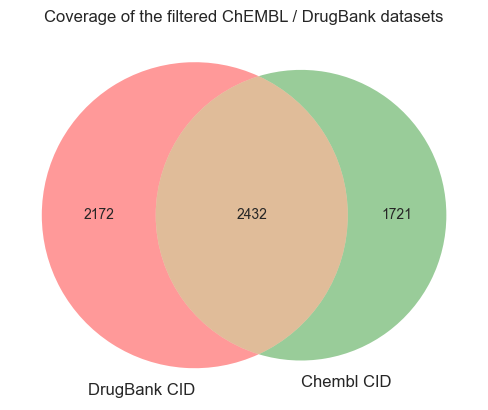

In [11]:
from matplotlib import pyplot as plt
import matplotlib_venn
_s_db_cid = set(df_db_drugs.chembl_id)
_s_chembl_cid = set(df_chembl_drugs.chembl_id)

matplotlib_venn.venn2([_s_db_cid, _s_chembl_cid], set_labels=["DrugBank CID", "Chembl CID"])
plt.title("Coverage of the filtered ChEMBL / DrugBank datasets")
print("Total DrugBank investigational / approved drugs without ChEMBL id:", sum(pd.isna(df_db_drugs.chembl_id)))